## Topic Modeling with Gensim LDASeq
Prior to running this code, complete the these notebooks: 
* Topic_Modeling_Altmetric_Data_Loading
* Topic_Modeling_Altmetric_Data_Preprocessing
* Topic_Modeling_Altmetric_Genism_Bag_of_Words

In [1]:
## General Dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys, os
import glob
from tika import parser # pip install tika
import inspect
import datetime
import pickle5 as pickle

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
#from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import ldaseqmodel


## Preprocessing
import spacy
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast

## Other Libraries
from operator import itemgetter

## ScikitLearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load the data from previous notebooks

In [4]:
## Load data csv as a dataframe
final_df = pd.read_csv("output/loading/final_df.csv", index_col=0) 

## Inspect output as needed
## final_df.head()

In [5]:
## Load data csv as a dataframe
test_df = pd.read_csv("output/processing/nostop_ngrams_partsofspeech_lemmatize.csv", index_col=0) 

## Inspect output as needed
## test_df.head()


In [6]:
## Open text_out_2 pickle file

file_name = "output/processing/texts_out_2.pkl"

open_file = open(file_name, "rb")
texts_out_2 = pickle.load(open_file)
open_file.close()

In [7]:
## Open bow_corpus pickle file

file_name = "output/bow/bow_corpus.pkl"

open_file = open(file_name, "rb")
bow_corpus = pickle.load(open_file)
open_file.close()

In [8]:
## Open dictionary pickle file

file_name = "output/bow/dictionary.pkl"

dictionary = corpora.Dictionary.load(file_name)

# open_file = open(file_name, "rb")
# dictionary = pickle.load(open_file)
# open_file.close()

## Resources
## https://stackoverflow.com/questions/58961983/how-do-you-save-a-model-dictionary-and-corpus-to-disk-in-gensim-and-then-load

In [9]:
## Open id_words_count pickle file

file_name = "output/bow/id_words_count.pkl"

open_file = open(file_name, "rb")
id_words_count = pickle.load(open_file)
open_file.close()

## Create timeslices from data

In [10]:
## Find the number of documents in each year. 
## This will be important for creating time-slices when using Dynamic Topic Modeling

time_series = final_df.groupby(['Year']).size()
print(type(time_series))
print(time_series)
print(time_series.index)

<class 'pandas.core.series.Series'>
Year
1990      1
1994      1
1995      3
1996      6
1997      2
1998      6
1999      6
2000      2
2001      2
2002      5
2003     14
2004     12
2005      9
2006     17
2007     12
2008     19
2009     39
2010     36
2011     18
2012     46
2013     60
2014     72
2015     52
2016     36
2017     97
2018    101
2019     56
2020      4
dtype: int64
Int64Index([1990, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
            2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='Year')


In [11]:
## Convert the time series into a list of "numbers"
## These will be the time-slices used for Dynamic Topic Modeling

time_slices = time_series.tolist()
print(time_slices)
print(len(time_slices))

[1, 1, 3, 6, 2, 6, 6, 2, 2, 5, 14, 12, 9, 17, 12, 19, 39, 36, 18, 46, 60, 72, 52, 36, 97, 101, 56, 4]
28


In [12]:
## Convert the time series index to a list of numbers
## These will be axis values in the visualization for Dynamic Topic Modeling

time_frame = time_series.index.tolist()
print(time_frame)
print(len(time_frame))

[1990, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
28


## Using the Gensim LDA Seq wrapper and applying the Dynamic Topic Model 

Use the Dynamic Topic Model (DTM) wrapper to identify how topics change over time.  

Resources: 
* <https://markroxor.github.io/gensim/static/notebooks/dtm_example.html>
* <http://users.umiacs.umd.edu/~jbg/nips_tm_workshop/30.pdf>
* <https://radimrehurek.com/gensim/models/ldaseqmodel.html>

lda = models.LdaModel(corpus, num_topics=45, id2word=dictionary, update_every=5, chunksize=10000,  passes=1)
* <https://stackoverflow.com/questions/49564330/extremely-slow-lda-training-model-with-large-corpora-python-gensim/49576266>

In [13]:
## Generate the LDASEQ model
## use the corpus from earlier
## use the dictonary from earlier
## use the time_slices from earlier
## use the optimal number of topics from earlier

ldaseq = ldaseqmodel.LdaSeqModel(corpus=bow_corpus, id2word=dictionary, time_slice=time_slices, num_topics=3)

## https://stackoverflow.com/questions/55490182/gensim-models-ldaseqmodel-py217-runtimewarning-divide-by-zero-encountered-in

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [14]:
## Get topics of each slice from the result
topics = []
i = 0
while i < 28:
    topic_i = []
    for topic in ldaseq.print_topics(time=i, top_terms=20):
        topic_i.append(topic)
    topics.append(topic_i)
    i += 1

# Save topics to CSV
df_topics = pd.DataFrame(topics)
with open(r"output/lda_seq/DTM_topics_timeslices.csv", 'w', newline="", encoding='utf-8') as file:
    df_topics.to_csv(file)


In [2]:
## Load csv as a dataframe

DTM_timeslices_df = pd.read_csv("output/lda_seq/DTM_topics_timeslices.csv", index_col=0) 
DTM_timeslices_df.head()


,0,1,2
0,"[('weight', 0.01856611068591241), ('smoke', 0....","[('pressure', 0.026641944029624384), ('black',...","[('weight', 0.016020200442245645), ('eat', 0.0..."
1,"[('weight', 0.01915874886477701), ('smoke', 0....","[('pressure', 0.026848166844545517), ('black',...","[('weight', 0.01615506422171722), ('eat', 0.01..."
2,"[('weight', 0.01990874070556419), ('smoke', 0....","[('pressure', 0.02719012900879411), ('black', ...","[('weight', 0.016380674209156683), ('eat', 0.0..."
3,"[('weight', 0.0215340313291921), ('smoke', 0.0...","[('pressure', 0.027959320713398652), ('black',...","[('weight', 0.01667698312002218), ('eat', 0.01..."
4,"[('weight', 0.02302574404094142), ('smoke', 0....","[('pressure', 0.026063107743525445), ('black',...","[('weight', 0.01689700711317626), ('eat', 0.01..."


In [3]:
print(DTM_timeslices_df.keys())
# DTM_timeslices_df.head()

# rename columns
DTM_timeslices_df.rename(columns = {'0':'Topic_0', '1': 'Topic_1', '2':'Topic_2' }, inplace = True) 

# iterating the columns 
for col in DTM_timeslices_df.columns: 
    print(col) 

DTM_timeslices_df.head()

Index(['0', '1', '2'], dtype='object')
Topic_0
Topic_1
Topic_2


,Topic_0,Topic_1,Topic_2
0,"[('weight', 0.01856611068591241), ('smoke', 0....","[('pressure', 0.026641944029624384), ('black',...","[('weight', 0.016020200442245645), ('eat', 0.0..."
1,"[('weight', 0.01915874886477701), ('smoke', 0....","[('pressure', 0.026848166844545517), ('black',...","[('weight', 0.01615506422171722), ('eat', 0.01..."
2,"[('weight', 0.01990874070556419), ('smoke', 0....","[('pressure', 0.02719012900879411), ('black', ...","[('weight', 0.016380674209156683), ('eat', 0.0..."
3,"[('weight', 0.0215340313291921), ('smoke', 0.0...","[('pressure', 0.027959320713398652), ('black',...","[('weight', 0.01667698312002218), ('eat', 0.01..."
4,"[('weight', 0.02302574404094142), ('smoke', 0....","[('pressure', 0.026063107743525445), ('black',...","[('weight', 0.01689700711317626), ('eat', 0.01..."


In [4]:
## Save dataframe to csv
with open(r"output/lda_seq/DTM_topics_timeslices_final.csv", 'w', encoding='utf-8') as file:
    DTM_timeslices_df.to_csv(file, index=True, line_terminator='\n')
    file.close()

In [18]:
#from collections import defaultdict
from ast import literal_eval

## Create a list of dictonaries to hold each timeslice for a topic
def convertTopicToDict(topic):
    
    ## Inspect the input as needed
    ## print(topic)
    ## print(type(topic))
    
    ## Create an empty list for the topic column
    topic_i=[]
    
    ## Itterate through each timeslice of the topic
    for line in topic:
        
        ## Inspect the input as needed
        ## print(line)
        ## print(type(line))
        
        ## Create an empty dictionary for the timeslice
        sub={}
        
        ## Convert string that looks like a tuple to a tuple
        line = ast.literal_eval(line)
        
        ## Iterate through each tuple in the timeslice and append to the sub dictionary
        for tup in line:
            sub[tup[0]]=tup[1]
        
        ## Append the sub dictionary to the topic list
        topic_i.append(sub)
        
    return topic_i

## Call the function as needed
final_topic_0 = convertTopicToDict(DTM_timeslices_df['Topic_0'])
final_topic_1 = convertTopicToDict(DTM_timeslices_df['Topic_1'])
final_topic_2 = convertTopicToDict(DTM_timeslices_df['Topic_2'])

## Inspect output of the function as needed
## print(final_topic_0)
## print(type(final_topic_0))  

## Resources
## https://www.geeksforgeeks.org/python-convert-list-of-tuples-to-dictionary-value-lists/

#######------------------------------------------------------

## Get the list of keys from the topic dictionary
def get_key_list(final_topic):
    
    key_list = []   
    
    for dictionary in final_topic:
        
        for key in dictionary.keys():
            key_list.append(key)
            
    # Remove duplicate keys from list using list comprehension + enumerate()
    final_key_list = [i for n, i in enumerate(key_list) if i not in key_list[:n]]
    
    return final_key_list

## Call the function as needed
final_key_list_0 = get_key_list(final_topic_0)
final_key_list_1 = get_key_list(final_topic_1)
final_key_list_2 = get_key_list(final_topic_2)

## Inspect output of the function as needed
## print(final_key_list_0)
## print(len(final_key_list_0))

## Resources
## https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/
## https://www.geeksforgeeks.org/python-ways-to-remove-duplicates-from-list/


######------------------------------------------------------

## Create a function to get terms and their probabilities from all topics
## Important: Add 0 if there is no probability for the term in a time slice
def get_term_prob (term, topic):
    
    term_list=[]
    term_dict = {}
    for item in topic:
        #print("This is item:", item)
        #print("This is item keys:", item.keys())
        if term in item.keys():
            #print("This is term:", term)
            for k, v in item.items():
                if k ==term:
                    term_list.append(v)
        else:
            term_list.append(0)
        
    #print(term_list)
    #print("This function-level term:", term)
    term_dict = dict({term : term_list})
    #print(term_dict)
    return term_dict

## Resources
## https://stackabuse.com/python-dictionary-tutorial/

######------------------------------------------------------


def createTermProbDictionary(term_list, topic):
    #print(term_list)
    final_list = []
    for term in term_list:
        #print(term)
        result =  get_term_prob(term, topic)
        final_list.append(result)
    return final_list

## Call the function as needed  
for_visual_topic_0 = createTermProbDictionary(final_key_list_0, final_topic_0)
for_visual_topic_1 = createTermProbDictionary(final_key_list_1, final_topic_1)
for_visual_topic_2 = createTermProbDictionary(final_key_list_2, final_topic_2)

## Inspect output of the function as needed
print("**************Visualize Topic 0*************", for_visual_topic_0) 
print("**************Visualize Topic 1*************",for_visual_topic_1) 
print("**************Visualize Topic 2*************",for_visual_topic_2) 


## Resources
## https://github.com/HuyenNguyenHelen/JMLA_CORD19-DS/blob/master/Research%20question%203/Graph_Topic%20evolution%20DTM.py

**************Visualize Topic 0************* [{'weight': [0.01856611068591241, 0.01915874886477701, 0.01990874070556419, 0.0215340313291921, 0.02302574404094142, 0.024659239309710066, 0.018866554422593673, 0.015205860302986212, 0.012530068278826712, 0.01049242869883001, 0.008792570741961749, 0.007422988903665038, 0.006459547034139514, 0.0056652089443992755, 0.005145247038691121, 0.004705423750406954, 0.004407774806920035, 0.004116454560492976, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'smoke': [0.017082678669603578, 0.017247092579497886, 0.017578516556970816, 0.018537567525889777, 0.01961685828621263, 0.020789377378708927, 0.017495627130725357, 0.015381866079649887, 0.013828589254240296, 0.012657496166896319, 0.011566204401663515, 0.01052106238290444, 0.010062332294380602, 0.009848327218649453, 0.008266216248157978, 0.007073673367128187, 0.006263795835622765, 0.0059863132788499475, 0.005897476358380559, 0.005864795603840865, 0.004886507856347502, 0.004295547384232928, 0.004126713219703648, 0.00

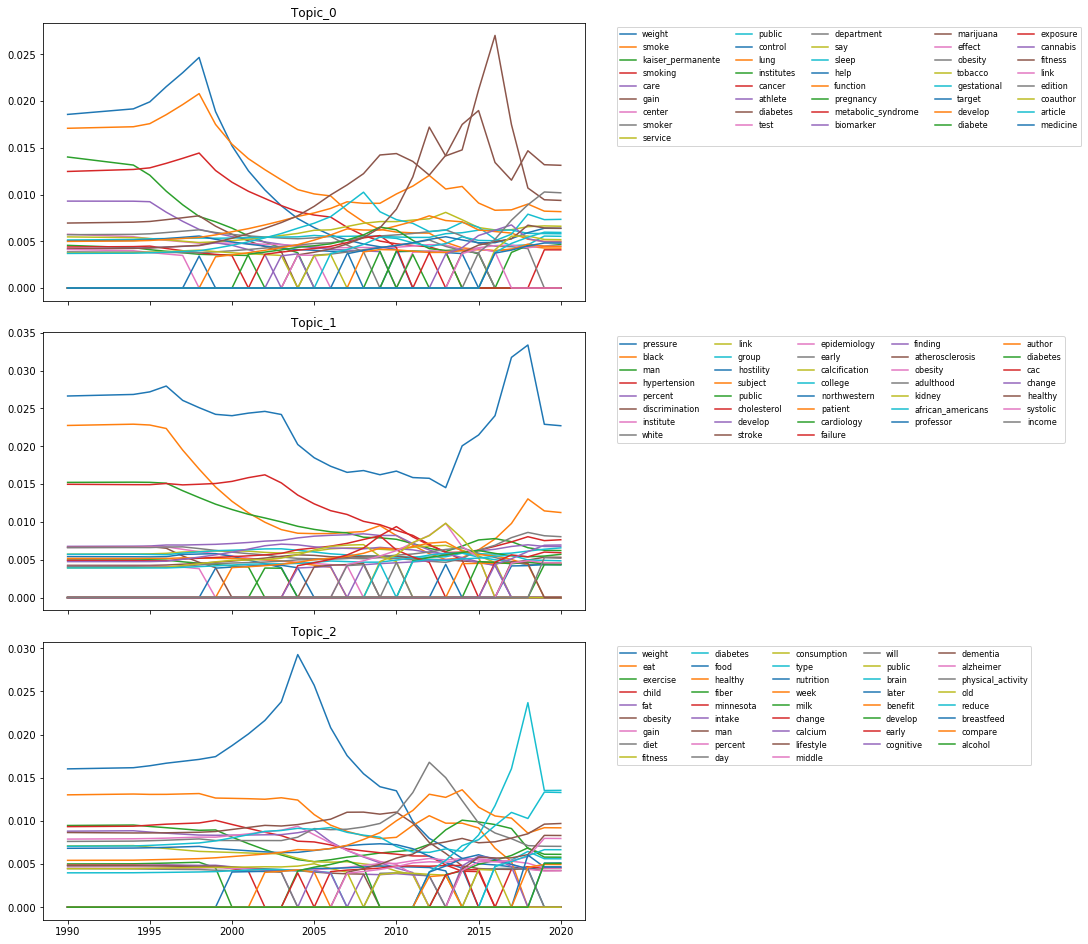

In [19]:
# Plot the topic evolution graph
# Create subplots
fig, (plt1,plt2, plt3) = plt.subplots(3,1,figsize=(15, 13), sharex=True, constrained_layout=True)

def create_topic_line_chart(topic, time, plt, chart_title):
    for dictionary in topic:
        #print(dictionary)
        
        for key, data_list in dictionary.items():
            plt.plot(time_frame, data_list, label=key)
           
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=5)
        plt.set_title(chart_title)
    ## loc='lower left', bbox_to_anchor=(0.01, 0.005)
    ## loc='upper right', bbox_to_anchor=(0.5, 0.5)
    ## loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5)
    return plt


plt1 = create_topic_line_chart(for_visual_topic_0, time_frame, plt1, "Topic_0")
plt2 = create_topic_line_chart(for_visual_topic_1, time_frame, plt2, "Topic_1")
plt3 = create_topic_line_chart(for_visual_topic_2, time_frame, plt3, "Topic_2")



# Create subplots
#fig, (plt1, plt2, plt3) = plt.subplots(3,1,figsize=(15, 13), sharex=True, constrained_layout=True)

# Save the graph
fig.savefig("output/lda_seq/DTM_timeslices_final.png")


## Resources
## https://www.geeksforgeeks.org/python-convert-list-of-tuples-to-list-of-list/
## https://www.geeksforgeeks.org/python-concatenate-values-with-same-keys-in-a-list-of-dictionaries/
## https://stackoverflow.com/questions/36313515/plotting-all-keys-of-a-dictionary-which-contains-list-as-values-python
## https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
## https://github.com/HuyenNguyenHelen/JMLA_CORD19-DS/blob/master/Research%20question%203/Graph_Topic%20evolution%20DTM.py